In [1]:
!pip install -q tensorflow-datasets

## Importação de Bibliotecas Necessárias
Importação das bibliotecas necessárias para o projeto, incluindo TensorFlow, TensorFlow Datasets e outras para visualização e manipulação de dados.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


## Carregamento do Dataset
Utilização do dataset Stanford Dogs para classificar raças de cachorros. Este dataset é carregado diretamente do TensorFlow Datasets.

In [3]:
(train_data, test_data), dataset_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUM6TQC/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteUM6TQC/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Pré-processamento e Visualização
As imagens são redimensionadas e normalizadas para o treinamento.

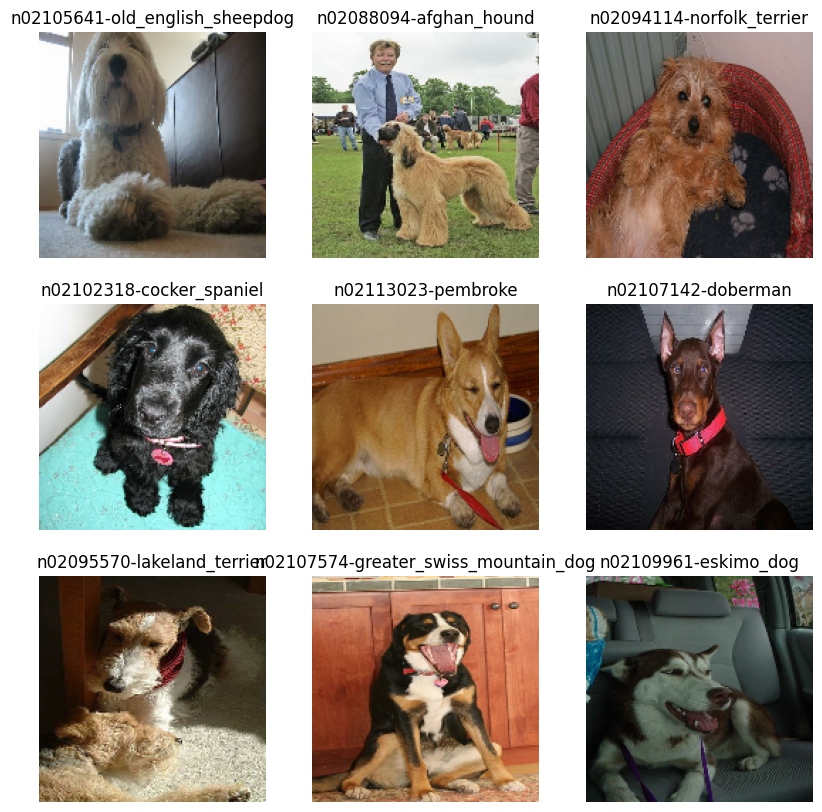

In [4]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [160, 160])
    image = (image / 255.0)
    return image, label

train_data = train_data.map(preprocess_image).shuffle(1000).batch(32)
test_data = test_data.map(preprocess_image).batch(32)

# Visualize some images
for image, label in train_data.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.title(dataset_info.features['label'].int2str(label[i]))
        plt.axis('off')


## Construção do Modelo
Transfer Learning com o modelo MobileNetV2 pré-treinado. Isso não só acelera o treinamento, mas também pode melhorar a precisão do modelo.

In [5]:
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(dataset_info.features['label'].num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 [==============================] - 0s 0us/step


## Treinamento do Modelo
O modelo é compilado e treinado com os dados de treino. É utilizado 'sparse_categorical_crossentropy' como função de perda e 'adam' como otimizador.

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
375/375 [==============================] - 478s 1s/step - loss: 1.4816 - accuracy: 0.5983 - val_loss: 1.0872 - val_accuracy: 0.6795
Epoch 2/10
375/375 [==============================] - 434s 1s/step - loss: 0.6058 - accuracy: 0.8106 - val_loss: 1.0649 - val_accuracy: 0.7005
Epoch 3/10
375/375 [==============================] - 383s 1s/step - loss: 0.3211 - accuracy: 0.8938 - val_loss: 1.0813 - val_accuracy: 0.7037
Epoch 4/10
375/375 [==============================] - 449s 1s/step - loss: 0.1655 - accuracy: 0.9472 - val_loss: 1.2025 - val_accuracy: 0.7000
Epoch 5/10
375/375 [==============================] - 442s 1s/step - loss: 0.1101 - accuracy: 0.9670 - val_loss: 1.2345 - val_accuracy: 0.7050
Epoch 6/10
375/375 [==============================] - 434s 1s/step - loss: 0.0807 - accuracy: 0.9788 - val_loss: 1.3041 - val_accuracy: 0.6985
Epoch 7/10
375/375 [==============================] - 378s 1s/step - loss: 0.0727 - accuracy: 0.9824 - val_loss: 1.3733 - val_accuracy: 0.7007

## Avaliação do Modelo


In [7]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy}")

269/269 [==============================] - 157s 583ms/step - loss: 1.7213 - accuracy: 0.6793
Test accuracy: 0.6792540550231934
